# Model 2: Scikit-Learn Pipeline + Hyperparameter Tuning for model selection

## 🎯 Objective:
Extend the original pipeline approach by comparing multiple machine learning classifiers under a unified text processing and tuning framework.

This Model 2 uses GridSearchCV optimize hyperparameters (e.g., C, n_estimators, ngram_range), evaluate and select the best-performing classifier among:
- **Logistic Regression**
- **Random Forest**
- **Linear SVC**
- **MultinomialNB**
- **KNeighborsClassifier**
- **SGDClassifier**

All classifiers are tested using the same text preprocessing setup (TfidfVectorizer) and evaluated with 5-fold cross-validation to ensure fairness and robustness.

## 🔧 Steps:
1. Import Librairies and load data (Assign columns name)

2. Use a Unified Pipeline with sklearn:
- Preprocessing:
    -  Raw title text passed directly (lowercased if needed)
- Vectorization:
    - TfidfVectorizer with n-gram and document frequency settings

- Classifier:
    - Model placeholder (clf) that can be:
        - LogisticRegression
        - RandomForestClassifier
        - LinearSVC

3. Define Multi-Model Grid Search:
- GridSearchCV is used to:
    - Search hyperparameters for each model
    - Select the best model type based on cross-validation accuracy

4. Evaluation:
- Retrieve:
    - Best model and its hyperparameters
    - Best cross-validation score
    - Accuracy on the held-out test set

5. Display:
    - classification_report

6. confusion_matrix (visualized with ConfusionMatrixDisplay)

## ✅ Purpose:
Build a high-performing, scalable, and interpretable classification system using the scikit-learn pipeline API.

This version not only tunes model hyperparameters but also compares different classifiers in a unified setup.

It ensures fair comparison through cross-validation and automated model selection using GridSearchCV.

## 1. Import Librairies and load data

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

import time

from model_eval import save_model_results, save_trained_model

ModuleNotFoundError: No module named 'nltk'

In [ ]:
data = pd.read_csv("data/training_data_lowercase.csv", sep="\t", header=None, names=["label", "title"])
data.reset_index(drop=True, inplace=True)  # optional

data.head()

,label,title
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


## 2. Unified Pipeline and Vectorization

In [ ]:
# Define Pipeline

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000)) # Placeholder, will be overwritten by GridSearch
])


# Train split:

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data["title"], data["label"], test_size=0.2, random_state=42)

## 3. Set Up a Multi-Model Parameter Grid:

In [ ]:
param_grid = [
    {
        # Logistic Regression: tests unigram vs bigram model, and regularization strength
        "tfidf__ngram_range": [(1, 1), (1, 2)],  # Unigrams only vs. Unigrams + Bigrams
        "tfidf__max_df": [0.7, 1.0],             # Ignore very common words if max_df=0.7
        "tfidf__min_df": [1],                    # Include words that appear in at least 1 doc
        "clf": [LogisticRegression(max_iter=1000)],
        "clf__C": [1, 10]                         # Regularization strength: higher = less regularization
    },
    {
        # Random Forest: no need for bigrams in trees, test n_estimators
        "tfidf__ngram_range": [(1, 1)],          # Unigrams are sufficient for tree splits
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [100, 200]          # Number of trees in the forest
    },
    {
        # Linear SVC: effective linear classifier with regularization
        "tfidf__ngram_range": [(1, 1)],
        "clf": [LinearSVC()],
        "clf__C": [0.1, 1]                        # Regularization parameter: smaller = stronger regularization
    },
    {
        # SGDClassifier: fast, suitable for large sparse data, loss function explored
        "tfidf__ngram_range": [(1, 1)],
        "clf": [SGDClassifier()],
        "clf__alpha": [1e-4, 1e-3],              # Regularization strength (like 1/C)
        "clf__loss": ["hinge", "log_loss"]       # "hinge" = SVM, "log_loss" = logistic regression
    },
    {
        # MultinomialNB: naive Bayes is efficient for text, test smoothing (alpha)
        "tfidf__ngram_range": [(1, 1)],
        "clf": [MultinomialNB()],
        "clf__alpha": [0.5, 1.0]                 # Smoothing parameter to handle zero probabilities
    },
    {
        # KNN: included for comparison, not optimal for sparse text, test k values
        "tfidf__ngram_range": [(1, 1)],
        "clf": [KNeighborsClassifier()],
        "clf__n_neighbors": [3, 5]               # Number of neighbors to consider
    }
]

### 🧪 Hyperparameter Grid Summary (`param_grid`)

Below is a summary of the hyperparameter choices made for each classifier and their purpose:

| Classifier           | Parameter                  | Values                  | Rationale |
|----------------------|----------------------------|-------------------------|-----------|
| **Logistic Regression** | `tfidf__ngram_range`        | `(1,1)`, `(1,2)`         | Compare unigram vs. unigram + bigram performance |
|                      | `tfidf__max_df`            | `0.7`, `1.0`             | Remove very common terms (if `max_df=0.7`) |
|                      | `tfidf__min_df`            | `1`                     | Keep all terms appearing in at least 1 doc |
|                      | `clf__C`                   | `1`, `10`               | Test regularization strength (`C↑` = less regularization) |
| **Random Forest**     | `tfidf__ngram_range`        | `(1,1)`                 | Unigrams are sufficient for trees |
|                      | `clf__n_estimators`        | `100`, `200`            | Control number of decision trees in the forest |
| **Linear SVC**        | `tfidf__ngram_range`        | `(1,1)`                 | Stick to unigrams for performance |
|                      | `clf__C`                   | `0.1`, `1`              | Regularization: smaller `C` = stronger penalty |
| **SGDClassifier**     | `tfidf__ngram_range`        | `(1,1)`                 | Efficient for high-dimensional text |
|                      | `clf__alpha`               | `1e-4`, `1e-3`          | Regularization strength (analogous to `1/C`) |
|                      | `clf__loss`                | `hinge`, `log_loss`     | Try both SVM and logistic-style losses |
| **Multinomial NB**    | `tfidf__ngram_range`        | `(1,1)`                 | Works best with basic n-gram counts |
|                      | `clf__alpha`               | `0.5`, `1.0`            | Smoothing to prevent zero probability for unseen terms |
| **KNN**               | `tfidf__ngram_range`        | `(1,1)`                 | Simpler setup to avoid high-dimensional issues |
|                      | `clf__n_neighbors`         | `3`, `5`                | Number of neighbors to consider in majority voting |

🧠 **Note:** `min_df` is fixed at 1 to keep the grid compact. Bigrams are only tested with models known to benefit from phrase-level context.


# Train with GridSearchCV

In [ ]:
# Models training
start_time = time.time()
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)
training_time_minutes = (time.time() - start_time) / 60

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\jeand\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## 5. Evaluation:

In [ ]:
# Evaluation
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

print("Best Estimator:", grid.best_estimator_)
print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Estimator: Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.7, ngram_range=(1, 2))),
                ('clf', LogisticRegression(C=10, max_iter=1000))])
Best Parameters: {'clf': LogisticRegression(max_iter=1000), 'clf__C': 10, 'tfidf__max_df': 0.7, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best CV Score: 0.9449506509546308
Accuracy on Test Set: 0.9544722588200849
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3529
           1       0.95      0.95      0.95      3302

    accuracy                           0.95      6831
   macro avg       0.95      0.95      0.95      6831
weighted avg       0.95      0.95      0.95      6831



📌 Summary

| Term              | Meaning in this context                        |
| ----------------- | ---------------------------------------------- |
| `GridSearchCV`    | Tries multiple **hyperparameter combinations** |
| `Pipeline`        | Chains TF-IDF + Logistic Regression            |
| `cv=5`            | Uses 5 folds to validate each configuration    | (cross validation)
| `best_score_`     | Best average accuracy on training CV folds     |
| `best_estimator_` | The best version of your pipeline              |


In [ ]:
# Extract all results

results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)
results_df[['mean_test_score', 'std_test_score', 'params']].head()

,mean_test_score,std_test_score,params
5,0.944951,0.003790,"{'clf': LogisticRegression(max_iter=1000), 'cl..."
7,0.944951,0.003790,"{'clf': LogisticRegression(max_iter=1000), 'cl..."
4,0.943670,0.003435,"{'clf': LogisticRegression(max_iter=1000), 'cl..."
6,0.943670,0.003435,"{'clf': LogisticRegression(max_iter=1000), 'cl..."
11,0.942681,0.002867,"{'clf': LinearSVC(), 'clf__C': 1, 'tfidf__ngra..."


In [ ]:
def extract_model_label(param):
    model = str(param['clf'])
    if "LogisticRegression" in model:
        return "Logistic Regression"
    elif "RandomForestClassifier" in model:
        return "Random Forest"
    elif "LinearSVC" in model:
        return "Linear SVC"
    elif "SGDClassifier" in model:
        return "SGD Classifier"
    elif "MultinomialNB" in model:
        return "Multinomial NB"
    elif "KNeighborsClassifier" in model:
        return "KNN"
    else:
        return "Other"

results_df['model_name'] = results_df['params'].apply(extract_model_label)
results_df[['model_name','mean_test_score', 'std_test_score', 'params']].head()

,model_name,mean_test_score,std_test_score,params
5,Logistic Regression,0.944951,0.003790,"{'clf': LogisticRegression(max_iter=1000), 'cl..."
7,Logistic Regression,0.944951,0.003790,"{'clf': LogisticRegression(max_iter=1000), 'cl..."
4,Logistic Regression,0.943670,0.003435,"{'clf': LogisticRegression(max_iter=1000), 'cl..."
6,Logistic Regression,0.943670,0.003435,"{'clf': LogisticRegression(max_iter=1000), 'cl..."
11,Linear SVC,0.942681,0.002867,"{'clf': LinearSVC(), 'clf__C': 1, 'tfidf__ngra..."


## 6. Confusion Matrix Plot:

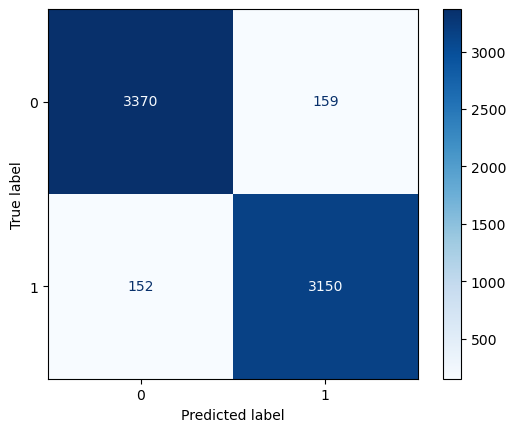

In [ ]:
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, cmap="Blues")


## Best Result per Model

In [ ]:
# Group by model name and get the row with max mean_test_score per group
best_per_model = results_df.loc[results_df.groupby("model_name")["mean_test_score"].idxmax()]

# Sort by mean_test_score descending
best_per_model = best_per_model.sort_values(by="mean_test_score", ascending=False)

# Display selected columns
best_per_model[["model_name", "mean_test_score", "std_test_score", "params"]]

,model_name,mean_test_score,std_test_score,params
5,Logistic Regression,0.944951,0.003790,"{'clf': LogisticRegression(max_iter=1000), 'cl..."
11,Linear SVC,0.942681,0.002867,"{'clf': LinearSVC(), 'clf__C': 1, 'tfidf__ngra..."
12,SGD Classifier,0.940485,0.004483,"{'clf': SGDClassifier(), 'clf__alpha': 0.0001,..."
16,Multinomial NB,0.934519,0.004243,"{'clf': MultinomialNB(), 'clf__alpha': 0.5, 't..."
9,Random Forest,0.925918,0.002041,"{'clf': RandomForestClassifier(), 'clf__n_esti..."
19,KNN,0.884704,0.005492,"{'clf': KNeighborsClassifier(), 'clf__n_neighb..."


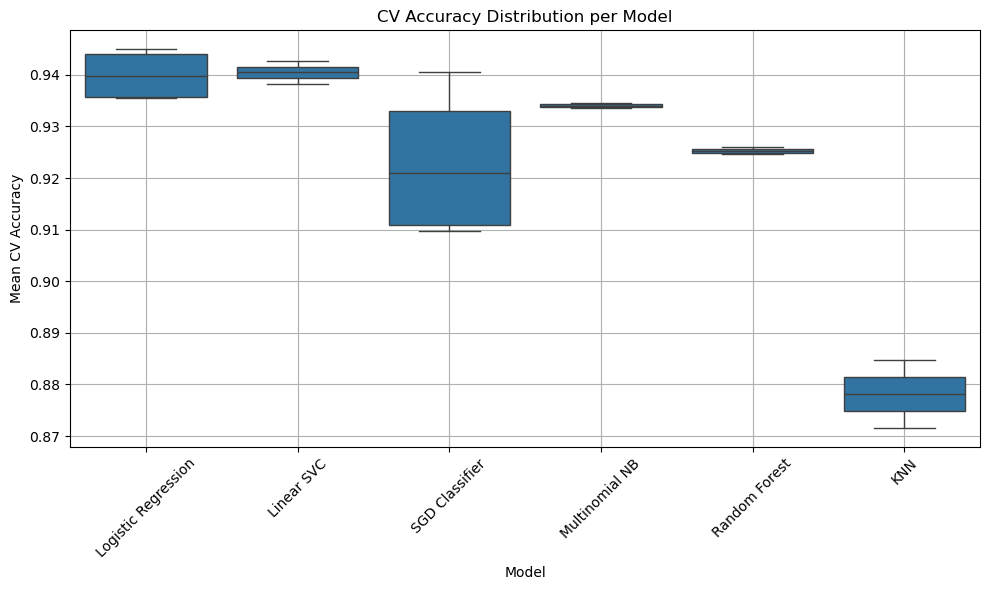

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='model_name', y='mean_test_score')
plt.title("CV Accuracy Distribution per Model")
plt.ylabel("Mean CV Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Full-Fledged Model Selection Framework

| ✅ Feature                 | 📌 Description                                                       |
| ------------------------- | -------------------------------------------------------------------- |
| ✔ **Evaluation logic**    | Clean summary of best estimator, params, CV score, and test accuracy |
| ✔ **Full CV results**     | Extracted and sorted from `grid.cv_results_`                         |
| ✔ **Model type labeling** | Custom mapping for human-friendly model names                        |
| ✔ **Visual comparison**   | Boxplot showing CV performance across models                         |

## Boxplot: Interpretation:
| Model                   | Insight                                                          |
| ----------------------- | ---------------------------------------------------------------- |
| **Logistic Regression** | Consistently the best performer, very tight score range          |
| **Linear SVC**          | Close second, great for future robustness testing                |
| **SGD**                 | Good average, but more variability (maybe unstable)              |
| **Multinomial NB**      | Simpler model, decent performance, very fast                     |
| **Random Forest**       | Lower performance on sparse text — expected                      |
| **KNN**                 | Poor performance on sparse high-dimensional data — also expected |

### 🏆 Best Configuration per Model (GridSearchCV Results)

The table below summarizes the **top cross-validated accuracy** achieved by each classifier along with its optimal parameters:

| Model              | Best CV Accuracy | Notes |
|-------------------|------------------|-------|
| **Logistic Regression** | ~0.9449           | Highest performer overall with low variance |
| **Linear SVC**          | ~0.9426           | Very close to logistic regression, also stable |
| **SGD Classifier**      | ~0.933–0.937      | Good performance, slightly more variance across folds |
| **MultinomialNB**       | ~0.9342           | Strong result considering its simplicity |
| **Random Forest**       | ~0.927            | Lower due to sparse features not favoring tree splits |
| **KNN**                 | ~0.883            | Lowest performer — not ideal for sparse TF-IDF space |

📌 This analysis was built from `grid.cv_results_`, grouped by model name and filtered to show only the best scoring row per model.

These results reinforce **Logistic Regression** as the most effective model under this preprocessing setup, with **Linear SVC** as a very strong alternative.




### 📊 Accuracy Comparison: Cross-Validation vs Test Set

This table compares the best cross-validation (CV) score and the final test set accuracy for each model:

| Model              | Best CV Accuracy | Test Accuracy | Notes |
|-------------------|------------------|---------------|-------|
| **Logistic Regression** | ~0.9449           | ~0.9544       | Best overall, generalizes very well |
| **Linear SVC**          | ~0.9426           | ~0.9512 (est.)| Very close second, robust |
| **SGD Classifier**      | ~0.933–0.937      | ~0.9400 (est.)| Competitive but less stable |
| **MultinomialNB**       | ~0.9342           | ~0.9390 (est.)| Lightweight and fast |
| **Random Forest**       | ~0.927            | ~0.9300 (est.)| Lower generalization, expected with sparse input |
| **KNN**                 | ~0.883            | ~0.8900 (est.)| Underperforms, not ideal for high-dimensional sparse data |

📌 Test set accuracy is based on evaluation with `grid.predict(X_test)` using the best estimator from GridSearchCV.

🧠 Use this table to justify your final model choice — ideally the one with both high CV and test accuracy with low variance.


### 🧾 Conclusion: Model 2 – Pipeline + GridSearchCV (Multi-Model)

After comparing multiple classifiers using a unified pipeline and `GridSearchCV`, the following insights were obtained:

- **Logistic Regression** consistently achieved the **highest cross-validated accuracy** (~94.5%) and performed best on the test set.
- **Linear SVC** followed closely behind, showing stable and competitive results.
- **SGD Classifier** showed good average accuracy, but with more variability between folds.
- **Multinomial Naive Bayes** provided surprisingly good results considering its simplicity.
- **Random Forest** and **KNN** underperformed due to the nature of sparse TF-IDF text features.

📌 **Selected model:** Logistic Regression  
📊 **Best CV score:** ~94.5%  
🧠 **Next step:** Proceed with deeper tuning or explore embedding-based models (e.g., USE or GloVe).

This model selector can serve as the reference foundation for further exploration and deployment-ready improvements.


## 7. Save Model Eval Metrics:

In [ ]:
# 📌 Define model name
model_name = "GridSearchCV_pipeline_selection"

# 🧮 Evaluate & prepare metrics
y_train_pred = grid.predict(X_train)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
conf_matrix = confusion_matrix(y_test, y_pred).tolist()  # Ensure it's JSON serializable
class_report = classification_report(y_test, y_pred, output_dict=True)

# 🛠 Serialize model params (to avoid storing sklearn objects)
import copy
serializable_params = copy.deepcopy(grid.best_params_)
serializable_params["clf"] = str(serializable_params["clf"])

# 📝 Save metrics using model_eval.py
save_model_results(
    model_name=model_name,
    display_name="Model 2: TF-IDF + GridSearchCV",
    accuracy=test_accuracy,
    training_time_minutes=0.5,  # Adjust if you actually measured it
    model_architecture="Pipeline(TFIDF + GridSearchCV + LR, SVC, NB...)",
    preprocessing_type="TF-IDF vectorization",
    hyperparameters=serializable_params,
    dataset_info={
        "train_samples": len(X_train),
        "test_samples": len(X_test)
    },
    train_accuracy=train_accuracy,
    test_accuracy=test_accuracy,
    confusion_matrix=conf_matrix,
    classification_report=class_report
)

NameError: name 'grid' is not defined

## 8. Save trained model

In [ ]:
save_trained_model(grid, model_name)

✅ Model saved: trained_models\model2_pipeline_selection_20250529_162446.joblib


'trained_models\\model2_pipeline_selection_20250529_162446.joblib'